<a href="https://colab.research.google.com/github/Olhaau/fl-official-statistics-addon/blob/main/_dev/06_insurance_federated_cv_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medical Insurance - a Federated Learning Use Case.

Wrapup

## Setup
---

In [6]:
# Is a repo-clone and installs needed (e.g. in colabs)? 
need_clone_install = True

### Pull Repo

In [7]:
if need_clone_install:
    import os
    
    # rm repo from gdrive
    if os.path.exists("fl-official-statistics-addon"):
      %rm -r fl-official-statistics-addon

    # clone
    !git clone https://github.com/Olhaau/fl-official-statistics-addon
    %cd fl-official-statistics-addon

    # pull (the currenct version of the repo)
    !git pull

Cloning into 'fl-official-statistics-addon'...
remote: Enumerating objects: 938, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 938 (delta 81), reused 14 (delta 10), pack-reused 818
Receiving objects: 100% (938/938), 34.69 MiB | 17.04 MiB/s, done.
Resolving deltas: 100% (441/441), done.
/content/fl-official-statistics-addon/fl-official-statistics-addon
Already up to date.


### Installs

In [8]:
#if need_clone_install: 
  #!pip install --quiet nest_asyncio==1.5.6
  #!pip install --quiet tensorflow_federated==0.20.0
  #!pip install --quiet tensorflow_addons==0.20.0
  # or !pip install -r requirements.txt

# save with: !pip freeze > requirements.txt
!python --version

Python 3.10.11


### Imports

In [9]:
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import tqdm
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
#import tensorflow_federated as tff
#from tensorflow_addons.metrics import RSquare
#import tensorflow_addons as tfa
#import nest_asyncio
from sklearn.metrics import r2_score

np.random.seed(0)

## Ingestion and data split
---

In [10]:
df = pd.read_csv("https://raw.githubusercontent.com/Olhaau/fl-official-statistics-addon/main/output/data/insurance-clean.csv", index_col = 0)
df.head()

,age,sex,bmi,children,smoker,region,charges,region0,region1,region2,region3
0,0.021739,0.0,0.321227,0.0,1.0,southwest,16884.92400,0.0,0.0,0.0,1.0
1,0.000000,1.0,0.479150,0.2,0.0,southeast,1725.55230,0.0,0.0,1.0,0.0
2,0.217391,1.0,0.458434,0.6,0.0,southeast,4449.46200,0.0,0.0,1.0,0.0
3,0.326087,1.0,0.181464,0.0,0.0,northwest,21984.47061,0.0,1.0,0.0,0.0
4,0.304348,1.0,0.347592,0.0,0.0,northwest,3866.85520,0.0,1.0,0.0,0.0


### Train-Test-Split

Cross Validation s. 
https://medium.com/the-owl/k-fold-cross-validation-in-keras-3ec4a3a00538 

In [11]:
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold

In [12]:
#nfolds = 5
#cv = StratifiedKFold(n_splits = nfolds, random_state = 42, shuffle= True)
#ind = 0
#for train, test in cv.split(df, df.region):
#  ind += 1
#  df.loc[train, 'fold' + str(ind)] = 'train'
#  df.loc[test,  'fold' + str(ind)] = 'test'


In [199]:
nfolds = 5
nreps = 5
cv = RepeatedStratifiedKFold(n_splits = nfolds, n_repeats = nreps, random_state = 42)
ind = 0
for train, test in cv.split(df, df.region):
  
  label = 'rep' + str(int(np.floor(ind / nfolds))) + '-fold' + str(ind % nfolds)
  df.loc[train, label] = 'train'
  df.loc[test,  label] = 'test'
  ind += 1

In [14]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges',
       'region0', 'region1', 'region2', 'region3', 'rep0-fold0', 'rep0-fold1',
       'rep0-fold2', 'rep0-fold3', 'rep0-fold4', 'rep1-fold0', 'rep1-fold1',
       'rep1-fold2', 'rep1-fold3', 'rep1-fold4'],
      dtype='object')

In [200]:
df.head()

,age,sex,bmi,children,smoker,region,charges,region0,region1,region2,...,rep3-fold0,rep3-fold1,rep3-fold2,rep3-fold3,rep3-fold4,rep4-fold0,rep4-fold1,rep4-fold2,rep4-fold3,rep4-fold4
0,0.021739,0.0,0.321227,0.0,1.0,southwest,16884.92400,0.0,0.0,0.0,...,train,train,train,train,test,train,train,train,test,train
1,0.000000,1.0,0.479150,0.2,0.0,southeast,1725.55230,0.0,0.0,1.0,...,train,train,train,train,test,train,train,test,train,train
2,0.217391,1.0,0.458434,0.6,0.0,southeast,4449.46200,0.0,0.0,1.0,...,train,train,train,test,train,test,train,train,train,train
3,0.326087,1.0,0.181464,0.0,0.0,northwest,21984.47061,0.0,1.0,0.0,...,train,test,train,train,train,train,train,train,test,train
4,0.304348,1.0,0.347592,0.0,0.0,northwest,3866.85520,0.0,1.0,0.0,...,train,train,test,train,train,train,test,train,train,train


#### Check

Check of the train test ratios for each region and fold.

In [16]:
ptrains = []
rep = 1

for fold in range(nfolds):
  label = 'rep'+ str(rep) +'-fold' + str(fold)
  ntrain = sum(df[label] == 'train')
  ntest = sum(df[label] == 'test')
  ptrain = ntrain / (ntrain + ntest); ptrains.append(ptrain)
  print(
      '(region, fold) =  (%s, %s), ntrain = %s, ntest = %s, ptrain = %.2f %%' %
      ('combined', fold, ntrain, ntest, ptrain * 100)
  )
print('=============================================================================')
for region in df.region.unique():
  for fold in range(5):
    df_temp = df[df.region == region]
    ntrain  = sum(df_temp[label] == 'train')
    ntest   = sum(df_temp[label] == 'test')
    ptrain  = ntrain / (ntrain + ntest); ptrains.append(ptrain)
    print(
        '(region, fold) = (%s, %s), ntrain =  %s, ntest =  %s, ptrain = %.2f %%' %
        (region, fold, ntrain, ntest, ptrain * 100)
    )


(region, fold) =  (combined, 0), ntrain = 1070, ntest = 268, ptrain = 79.97 %
(region, fold) =  (combined, 1), ntrain = 1070, ntest = 268, ptrain = 79.97 %
(region, fold) =  (combined, 2), ntrain = 1070, ntest = 268, ptrain = 79.97 %
(region, fold) =  (combined, 3), ntrain = 1071, ntest = 267, ptrain = 80.04 %
(region, fold) =  (combined, 4), ntrain = 1071, ntest = 267, ptrain = 80.04 %
(region, fold) = (southwest, 0), ntrain =  260, ntest =  65, ptrain = 80.00 %
(region, fold) = (southwest, 1), ntrain =  260, ntest =  65, ptrain = 80.00 %
(region, fold) = (southwest, 2), ntrain =  260, ntest =  65, ptrain = 80.00 %
(region, fold) = (southwest, 3), ntrain =  260, ntest =  65, ptrain = 80.00 %
(region, fold) = (southwest, 4), ntrain =  260, ntest =  65, ptrain = 80.00 %
(region, fold) = (southeast, 0), ntrain =  292, ntest =  72, ptrain = 80.22 %
(region, fold) = (southeast, 1), ntrain =  292, ntest =  72, ptrain = 80.22 %
(region, fold) = (southeast, 2), ntrain =  292, ntest =  72, ptr

## Model

In [201]:
from keras.models import Sequential
from keras.layers import Dense, InputLayer


def build_model(units = [40, 40, 20], activations = ['relu'] * 3, input_shape = [9]):
  model = Sequential()
  model.add(InputLayer(input_shape = input_shape))
  for ind in range(len(units)):
    model.add(Dense(units = units[ind], activation = activations[ind]))
  model.add(Dense(1))
  return model

build_model().summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_132 (Dense)           (None, 40)                400       
                                                                 
 dense_133 (Dense)           (None, 40)                1640      
                                                                 
 dense_134 (Dense)           (None, 20)                820       
                                                                 
 dense_135 (Dense)           (None, 1)                 21        
                                                                 
Total params: 2,881
Trainable params: 2,881
Non-trainable params: 0
_________________________________________________________________


## Centralized neural networks
---

### Training
---

#### Setup

In [202]:
# inputs
features = ['age', 'sex', 'bmi', 'children', 'smoker'
            , 'region0', 'region1', 'region2', 'region3']
target = 'charges'

In [203]:
# helpers

# FIXME: doc
def train_model(X_train, y_train, epochs = 100, seed = 42, verbose = 0, use_gpu = True):
  
  # generate a model
  model = build_model(input_shape = [X_train.shape[1]])
  model.compile(
        loss = 'mean_squared_error', 
        optimizer = tf.optimizers.Adam(learning_rate = .05),
        # <- Adam + lower learning rate
        metrics = ["mae", 'mean_squared_error', r2_score], 
        run_eagerly = True
        )

  # train 
  tf.random.set_seed(seed)
  rtime = time.time() 
  if use_gpu:
    with tf.device('/device:GPU:0'):
      hist = model.fit(
          X_train, y_train,
          batch_size = 128, 
          # <- higher batch_size
          shuffle = True,
          validation_split = 0.2,
          epochs = epochs,
          verbose = verbose
      )
  else:
    hist = model.fit(
      X_train, y_train,
      batch_size = 128, 
      # <- higher batch_size
      shuffle = True,
      validation_split = 0.2,
      epochs = epochs,
      verbose = verbose
    )
  
  print('loss - train: %.2f' % hist.history['loss'][-1])
  print('loss - test:  %.2f' % hist.history['val_loss'][-1])  
  rtime = time.time() - rtime
  print('time - train: %.2f' % (rtime / 60))
  return hist


def apply_train_model(ind, epochs = 100, seed = 42, verbose = 0, use_gpu = True):
  # label
  rep = int(np.floor(ind / nfolds))
  fold = ind % nfolds
  label = 'rep' + str(rep) + '-fold' + str(fold)
  print('====== rep %s - fold %s  ======' % (rep, fold))

  # train data
  X_train = df.loc[df[label] == 'train', features]
  y_train = df[[target]][df[label] == 'train']

  # apply train_model
  hist = train_model(X_train, y_train, epochs = epochs, seed = seed, verbose = verbose, use_gpu = use_gpu)

  return hist

def test_model(hist, X_test, y_test, verbose = 0):
  rtime = time.time() 
  perf = hist.model.evaluate(X_test, y_test, verbose = 0)[1:]
  rtime = time.time() - rtime
  if verbose != 0: print('time - test: %.2f' % (rtime / 60))
  return perf

def apply_test_model(ind, hist, verbose = 0):
  # label
  rep = int(np.floor(ind / nfolds))
  fold = ind % nfolds
  label = 'rep' + str(rep) + '-fold' + str(fold)
  if verbose != 0: print('====== rep %s - fold %s  ======' % (rep, fold))

  # test data
  X_test = df.loc[df[label] == 'test', features]
  y_test = df[[target]][df[label] == 'test']

  perf = test_model(hist, X_test, y_test, verbose = verbose)
  if verbose != 0: print('Performance: ', perf)
  return perf


#### Compiling

In [214]:
%%time

hists = []
for ind in range(nreps * nfolds):
  hist = apply_train_model(ind, epochs = 100, seed = 42)
  hists.append(hist)

====== rep 0 - fold 0  ======
loss - train: 19698436.00
loss - test:  27197476.00
time - train: 2.37
====== rep 0 - fold 1  ======
loss - train: 21257532.00
loss - test:  21968348.00
time - train: 2.37
====== rep 0 - fold 2  ======
loss - train: 23607642.00
loss - test:  27468826.00
time - train: 2.37
====== rep 0 - fold 3  ======
loss - train: 22416328.00
loss - test:  27981272.00
time - train: 1.79
====== rep 0 - fold 4  ======
loss - train: 21718478.00
loss - test:  23609820.00
time - train: 2.37
====== rep 1 - fold 0  ======


ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-86240' coro=<Client._gather.<locals>.wait() done, defined at /usr/local/lib/python3.10/dist-packages/distributed/client.py:2122> exception=AllExit()>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/distributed/client.py", line 2131, in wait
    raise AllExit()
distributed.client.AllExit
ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-86241' coro=<Client._gather.<locals>.wait() done, defined at /usr/local/lib/python3.10/dist-packages/distributed/client.py:2122> exception=AllExit()>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/distributed/client.py", line 2131, in wait
    raise AllExit()
distributed.client.AllExit
ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-86242' coro=<Client._gather.<locals>.wait() done, defined at /usr/local/lib/python3.10/dist-packages/dist

loss - train: 21611808.00
loss - test:  29246806.00
time - train: 1.99
====== rep 1 - fold 1  ======
loss - train: 21758966.00
loss - test:  26145726.00
time - train: 2.37
====== rep 1 - fold 2  ======
loss - train: 19556092.00
loss - test:  20550462.00
time - train: 2.37
====== rep 1 - fold 3  ======
loss - train: 23077768.00
loss - test:  30942960.00
time - train: 1.95
====== rep 1 - fold 4  ======
loss - train: 24228730.00
loss - test:  23941902.00
time - train: 1.95
====== rep 2 - fold 0  ======
loss - train: 21894470.00
loss - test:  24510942.00
time - train: 1.84
====== rep 2 - fold 1  ======
loss - train: 21080444.00
loss - test:  24192918.00
time - train: 1.80
====== rep 2 - fold 2  ======
loss - train: 20050010.00
loss - test:  26525838.00
time - train: 1.76
====== rep 2 - fold 3  ======
loss - train: 23231900.00
loss - test:  23379964.00
time - train: 1.67
====== rep 2 - fold 4  ======
loss - train: 22338584.00
loss - test:  29651972.00
time - train: 1.72
====== rep 3 - fold 

#### Paralellization

usable libraries:

- dask
- multiprocessing
- joblib

##### Dask

In [204]:
#import dask 
#from dask.distributed import Client

#client = Client()
#client

/usr/local/lib/python3.10/dist-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37509 instead
  warnings.warn(
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:37149
INFO:distributed.scheduler:  dashboard at:           127.0.0.1:37509
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:43719'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:37749'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:46753', name: 1, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:46753
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:54068
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:38521', name: 0, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker comp

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:37509/status,
Dashboard: http://127.0.0.1:37509/status,Workers: 2
Total threads: 2,Total memory: 12.68 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37149,Workers: 2
Dashboard: http://127.0.0.1:37509/status,Total threads: 2
Started: Just now,Total memory: 12.68 GiB
Comm: tcp://127.0.0.1:38521,Total threads: 1
Dashboard: http://127.0.0.1:41533/status,Memory: 6.34 GiB
Nanny: tcp://127.0.0.1:43719,


In [210]:
#@dask.delayed 
#def task(ind): return apply_train_model(ind=ind, epochs = 100, seed = 42, use_gpu = True)

#hists_lazy = [task(ind) for ind in range(nreps * nfolds)] 

In [211]:
#%%time
#hists_dask = dask.compute(*hists_lazy)

KeyboardInterrupt: ignored

Faster without gpu? no.

In [212]:
#%%time

#@dask.delayed 
#def task(ind): return apply_train_model(ind=ind, epochs = 100, seed = 42, use_gpu = False)

#hists_lazy2 = [task(ind) for ind in range(nreps * nfolds)] 

#hists_dask2 = dask.compute(*hists_lazy2)

### Evaluation
---

In [215]:
# calculate the performance
perfs = []
for ind in range(nreps * nfolds):
  perf = apply_test_model(ind, hist = hists[ind])
  perfs.append(perf)

#### Test Performance (Individual, Table)

In [216]:
perfs_df = pd.DataFrame(perfs, columns = ["MAE", 'MSE', 'RSQ']).assign(
    RMSE   = lambda x: np.sqrt(x.MSE),
    RSQ_pct = lambda x: x.RSQ * 100
)
perfs_df[['MAE', 'RMSE', 'RSQ_pct']].round(2)

,MAE,RMSE,RSQ_pct
0,2553.68,5059.48,84.22
1,3194.93,5408.56,75.51
2,2542.17,4308.15,85.26
3,2636.80,4431.53,84.31
4,2750.63,5140.89,78.48
5,2850.71,4594.96,83.95
6,3018.96,4922.16,78.41
7,3391.02,5959.42,72.44
8,3332.47,4657.54,80.80
9,2917.42,4489.40,85.55


#### Test Performance (Aggregated, Table)

In [220]:
perfs_df[['MAE', 'RMSE', 'RSQ_pct']].describe()[1:].round(2)

,MAE,RMSE,RSQ_pct
mean,2964.17,4888.55,80.86
std,299.17,397.36,3.96
min,2495.17,4308.15,72.44
25%,2750.63,4597.04,78.48
50%,2928.97,4763.32,80.67
75%,3161.97,5059.48,83.95
max,3528.03,5959.42,87.94


#### Train Performance Plot

In [218]:
def plot_perf(hist, msr = 'loss'):
  """Plot the training history and save the figure.
  :param hist: The history object including the metrics to plot
  :type hist: keras.callbacks.History
  :param msr: The metrics to plot
  :type msr: str, optional
  """
  plt.plot(hist.history[msr])
  plt.plot(hist.history['val_' + msr])
  plt.ylabel(msr)
  plt.xlabel('epoch')
  plt.legend(['train', 'eval'], loc='upper left')

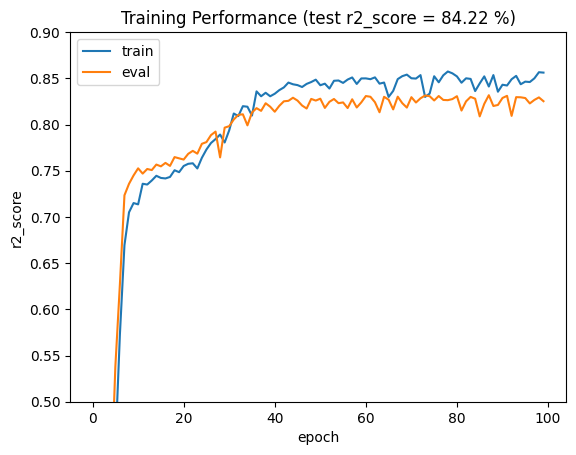

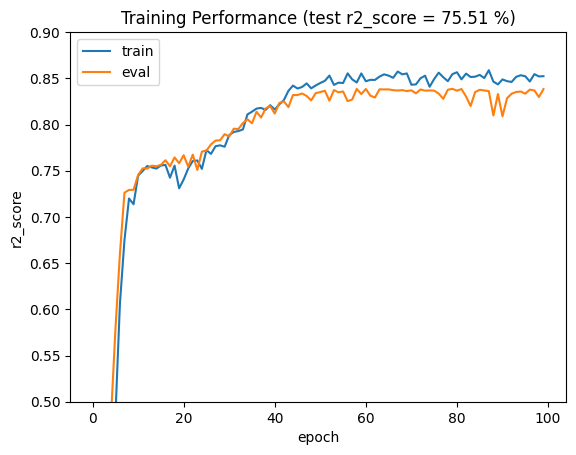

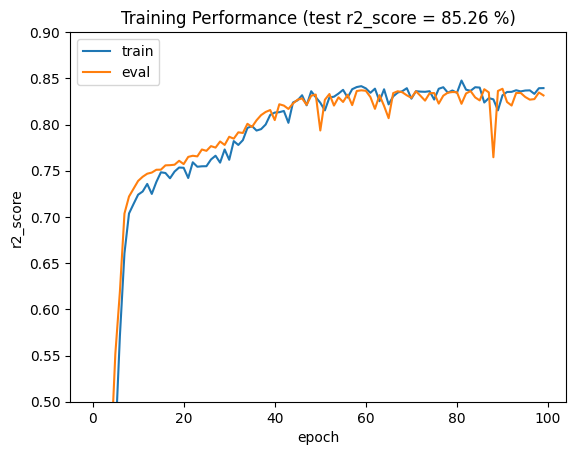

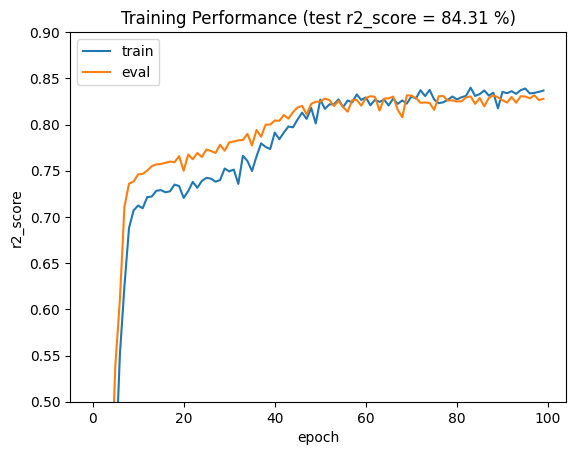

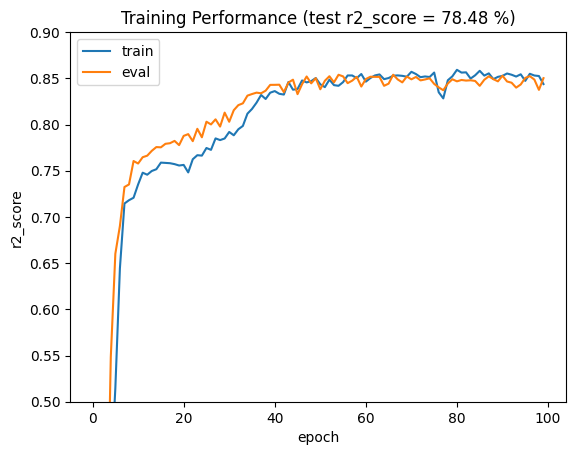

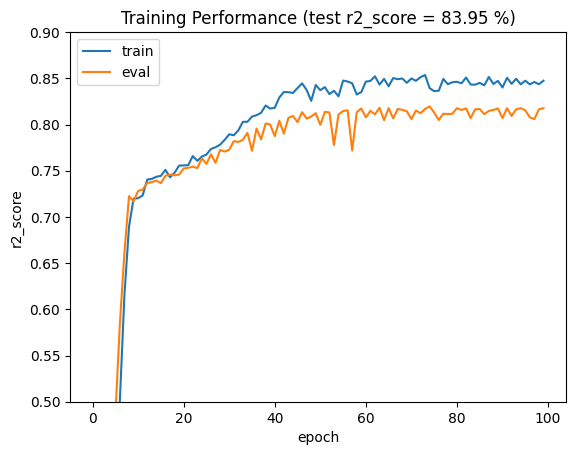

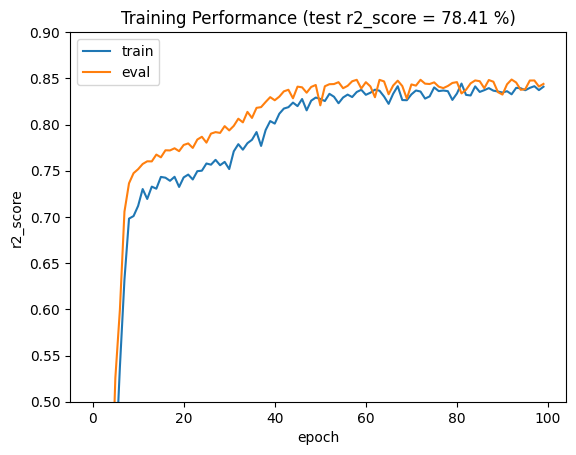

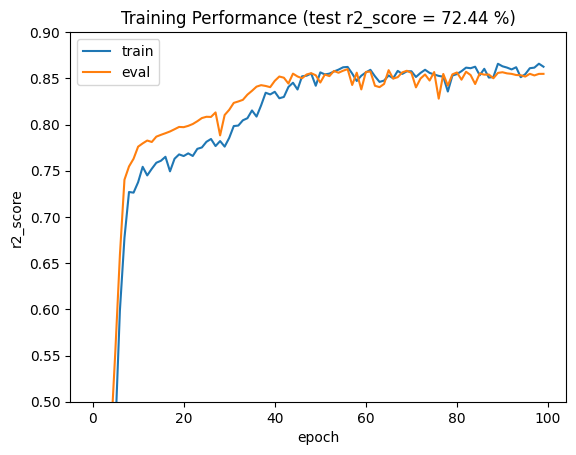

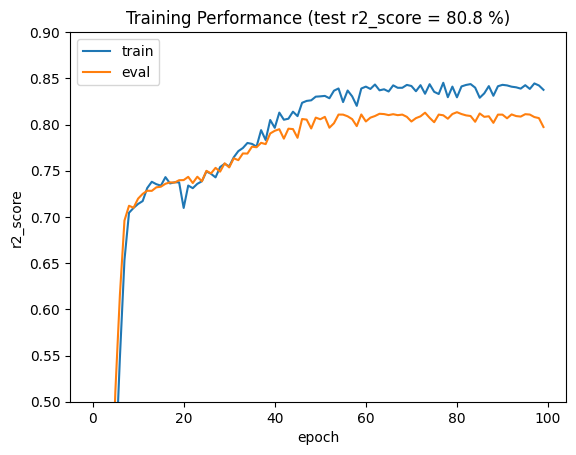

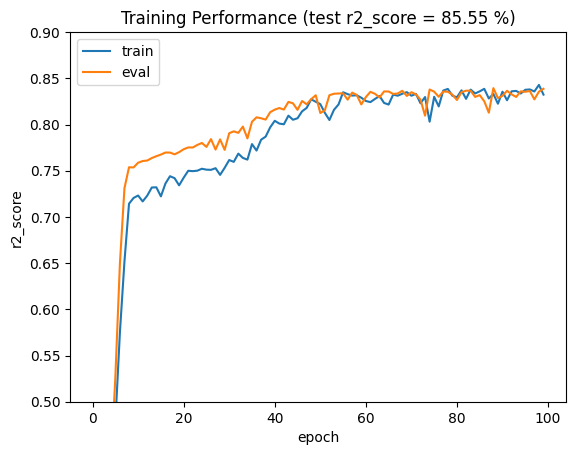

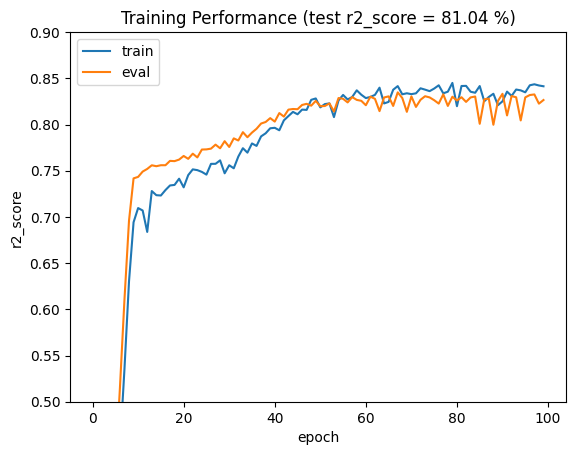

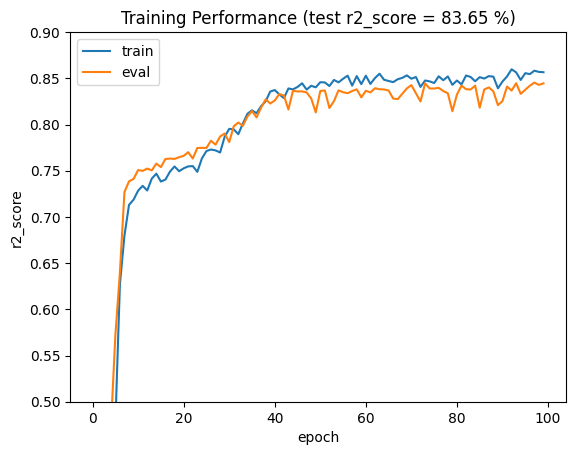

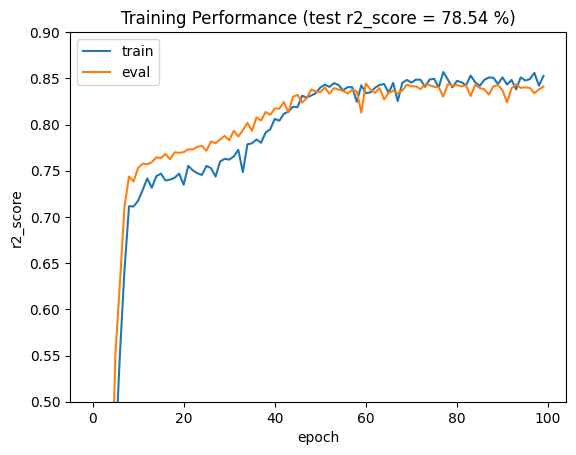

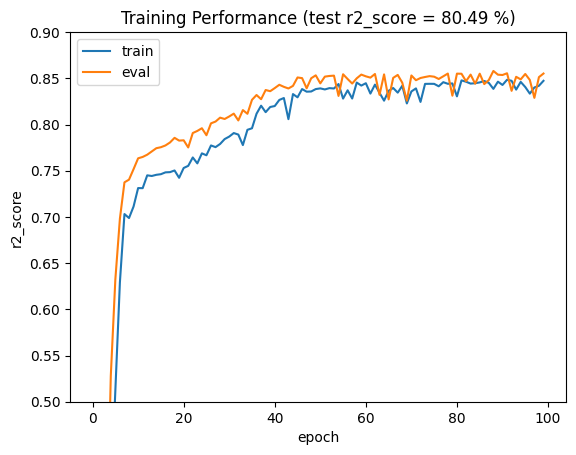

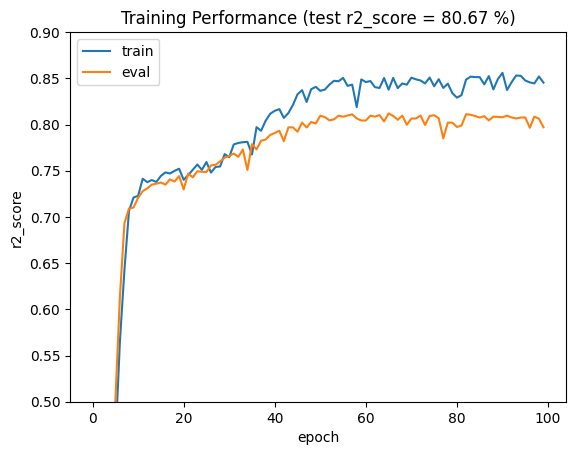

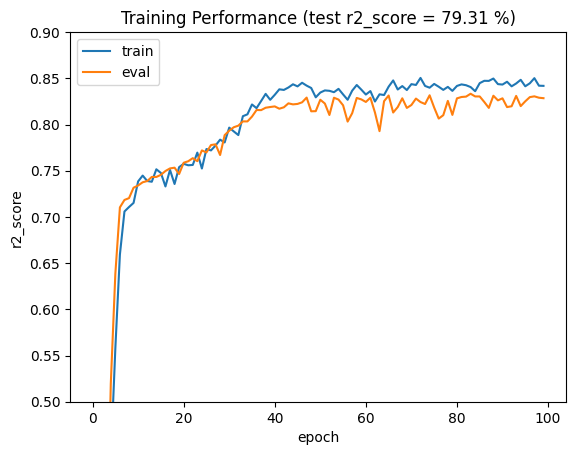

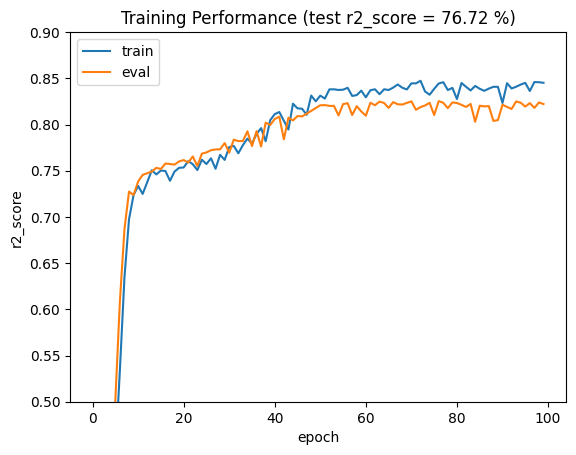

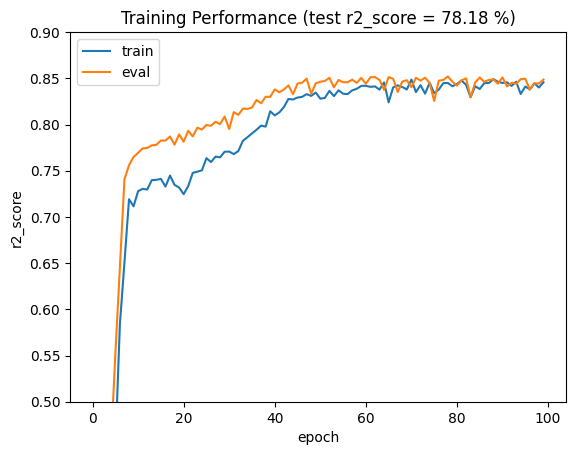

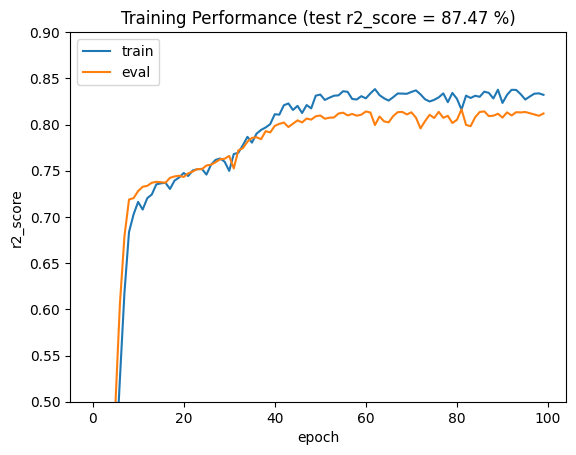

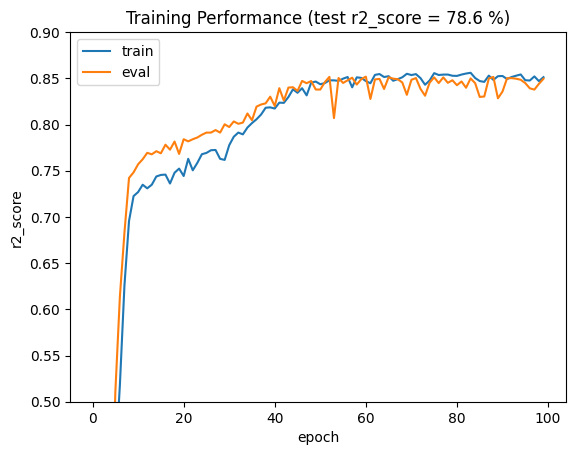

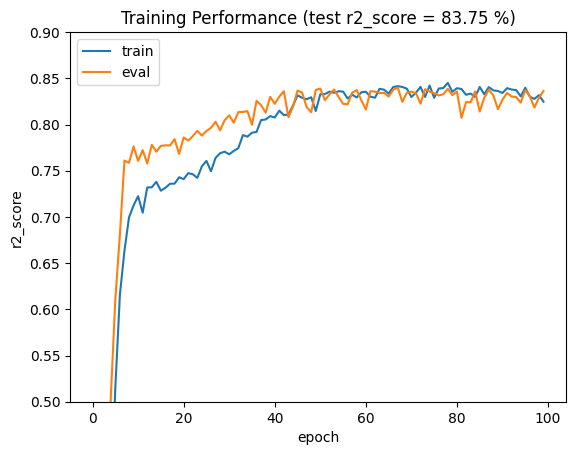

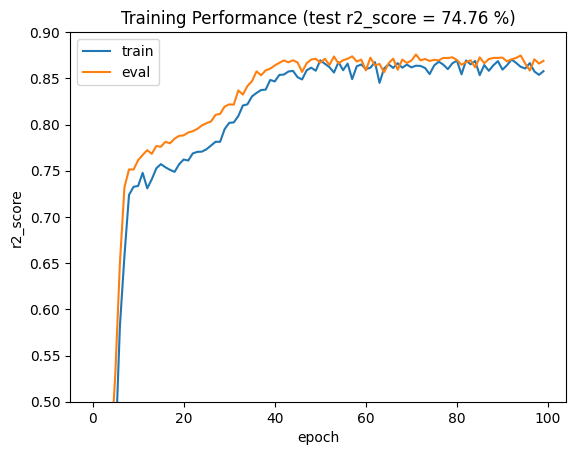

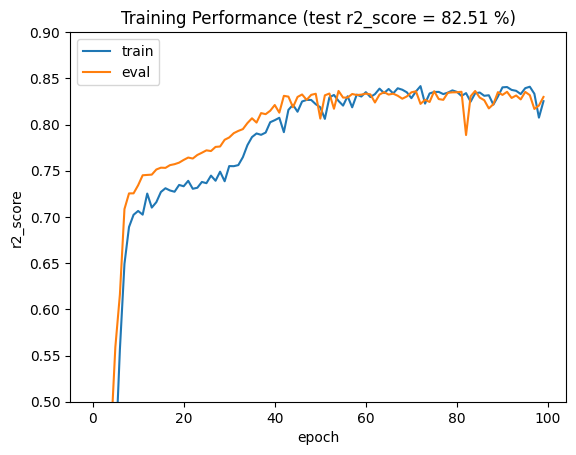

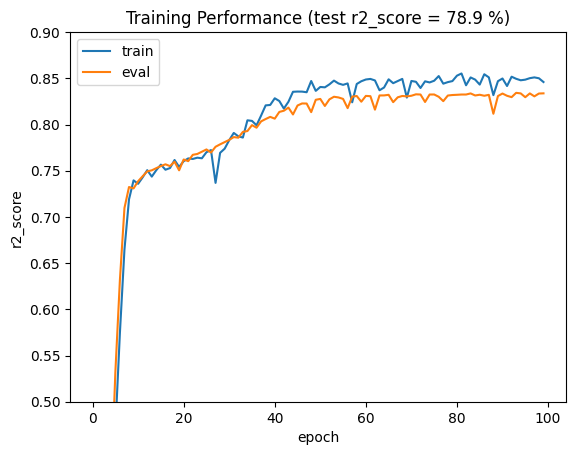

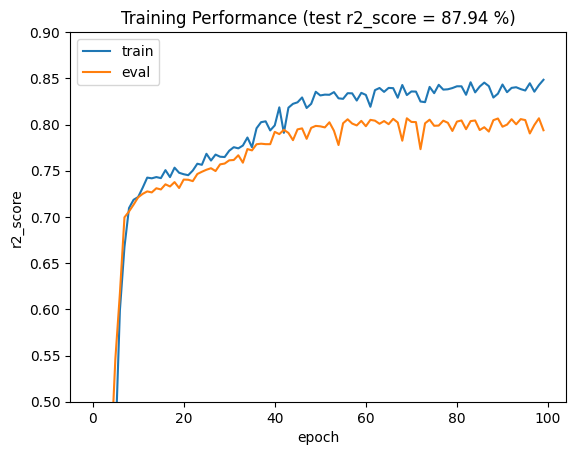

In [221]:
for ind in range(len(hists)):
  plot_perf(hists[ind], 'r2_score')
  plt.title('Training Performance (test r2_score = '+str(round(perfs[ind][2] * 100, 2))+ " %)")
  plt.ylim([0.5, 0.9])
  plt.show()